In [1]:
import simpy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt
from itertools import product

from tqdm import tqdm_notebook

In [2]:
import importlib
try:
    importlib.reload(sm)
except:
    import sim_model as sm

Simpy documentation - https://simpy.readthedocs.io/en/latest/contents.html 

# Data preparation

In [3]:
try:
    simulation_ds = pd.read_csv('simulation_ds.csv', index_col=0)
except:
    simulation_ds = pd.DataFrame(columns=[
    'n_lines', 'n_vip_lines', 'cost', 'clever_wait',
    'gold_wait', 'silver_wait', 'regular_wait',
    'vip_no_lines', 'regular_no_lines',
    'gold_7', 'gold_8', 'gold_9', 'gold_10', 'gold_11',
    'silver_7', 'silver_8', 'silver_9', 'silver_10', 'silver_11',
    'regular_7', 'regular_8', 'regular_9', 'regular_10', 'regular_11',
    ])

# Set simulation and run

In [4]:
n_lines = 55
n_vip_lines = 5

In [5]:
op_time_ds = pd.DataFrame(index=range(7,12))
op_time_ds['gold'] = [3, 4, 0, 0, 3]
op_time_ds['silver'] = [5, 6, 0, 5, 4]
op_time_ds['regular'] = [6, 10, 10, 7,6]
op_time_ds

,gold,silver,regular
7,3,5,6
8,4,6,10
9,0,0,10
10,0,5,7
11,3,4,6


In [6]:
client_ds, op_ds, sim_data = sm.run_simulation(op_time_ds, n_lines, n_vip_lines, verb=True)

A Jupyter Widget

In [7]:
client_ds['queue_duration_time_sec'] = [x.seconds for x in client_ds['queue_duration_time_dt']]

In [8]:
wait_table = client_ds[['type', 'hour','queue_duration_time_sec']].dropna().pivot_table(
    index='hour',columns='type', values='queue_duration_time_sec', aggfunc='mean').reindex(columns=['gold','silver','regular'])

In [9]:
client_ds, op_ds, sim_data = sm.run_simulation(op_time_ds, n_lines, n_vip_lines, verb=True, wait_table=wait_table)

A Jupyter Widget

In [10]:
simulation_ds = simulation_ds.append(sim_data, ignore_index=True)
simulation_ds.to_csv('simulation_ds.csv')

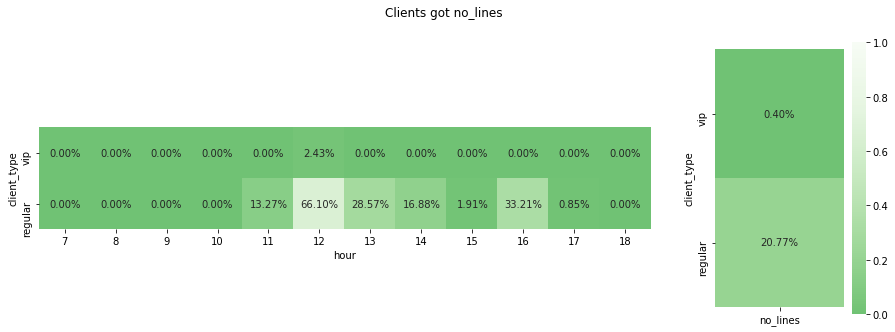

In [11]:
sm.plot_clients_no_lines(client_ds)

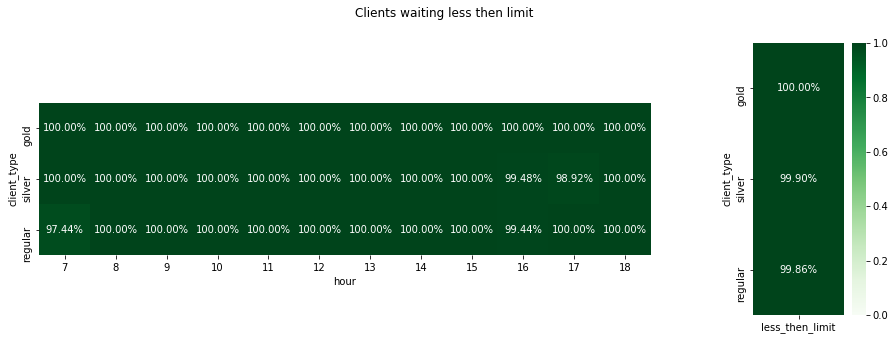

In [12]:
sm.plot_clients_waitings(client_ds)

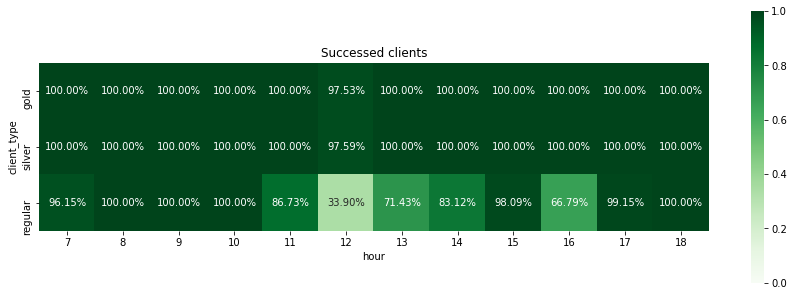

In [13]:
sm.plot_clients_success(client_ds)

# Find best parameters

In [14]:
cds = simulation_ds.copy()

In [15]:
cds = cds[(cds['gold_wait']>=0.98)&(cds['silver_wait']>=0.95)&(cds['regular_wait']>=0.85)
   &(cds['regular_no_lines']<=0.2)&(cds['vip_no_lines']<=0.02)&(cds['clever_wait']==True)]

In [16]:
cds.shape

(2, 24)

In [17]:
cds.sort_values('cost').iloc[0]

n_lines                 55.000000
n_vip_lines              5.000000
cost                262800.000000
gold_wait                1.000000
silver_wait              0.999495
regular_wait             0.996037
vip_no_lines             0.008728
regular_no_lines         0.189440
gold_7                   3.000000
gold_8                   4.000000
gold_9                   0.000000
gold_10                  0.000000
gold_11                  3.000000
silver_7                 5.000000
silver_8                 6.000000
silver_9                 0.000000
silver_10                5.000000
silver_11                4.000000
regular_7                6.000000
regular_8               10.000000
regular_9               10.000000
regular_10               7.000000
regular_11               6.000000
clever_wait              1.000000
Name: 81, dtype: float64